In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing
- get rid of nulls
- encoding categorical data

In [4]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
# any one without a cabin just place None
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: 'None' if pd.isna(x) else x)
test_df['Cabin'] = test_df['Cabin'].apply(lambda x: 'None' if pd.isna(x) else x)

In [6]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked        True
dtype: bool

In [7]:
# find the most common location embarked
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

In [8]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [9]:
# Age is usually correlated with the amount of money they make and sex. 
# find the average age based on sex and passenger class (1st 2nd or 3rd)
corr_df = train_df.groupby(['Pclass', 'Sex']).Age.mean().reset_index()

def update_age(params):
    pclass = params.iloc[0]
    sex = params.iloc[1]
    age = params.iloc[2]
    if pd.isnull(age):
        age = float(corr_df[(corr_df['Pclass'] == pclass) & (corr_df['Sex'] == sex)]['Age'].iloc[0])
    return age

train_df['Age'] = train_df[['Pclass', 'Sex', 'Age']].apply(lambda x : update_age(x), axis = 1)

In [10]:
corr_df = test_df.groupby(['Pclass', 'Sex']).Age.mean().reset_index()

test_df['Age'] = test_df[['Pclass', 'Sex', 'Age']].apply(lambda x : update_age(x), axis = 1)

In [11]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [12]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin          False
Embarked       False
dtype: bool

In [13]:
corr_df = train_df.groupby(['Pclass']).Fare.mean().reset_index()

def update_fare(params):
    pclass = params.iloc[0]
    fare = params.iloc[1]
    if pd.isna(fare):
        fare = float(corr_df[(corr_df['Pclass'] == pclass)]['Fare'].iloc[0])
    return fare

test_df['Fare'] = test_df[['Pclass', 'Fare']].apply(lambda x : update_fare(x), axis = 1)

In [14]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [15]:
# get rid of uneeded columns 
train_df = train_df.drop(columns=['Name', 'Ticket', 'Cabin'])
test_df = test_df.drop(columns=['Name', 'Ticket', 'Cabin'])
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## Data Analysis

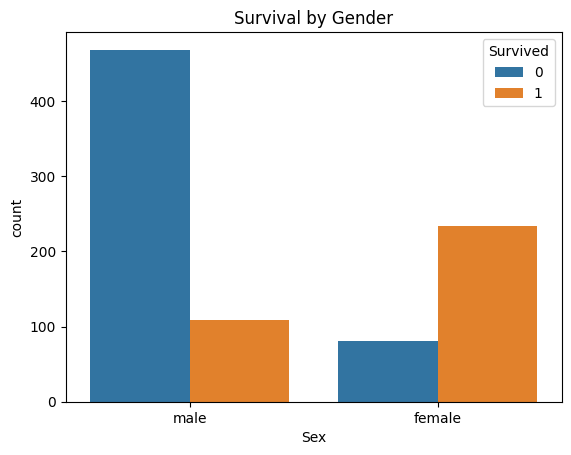

In [16]:
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Gender')
plt.show()

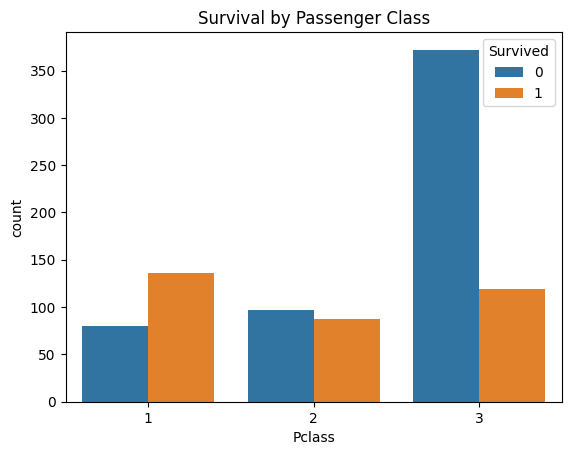

In [17]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

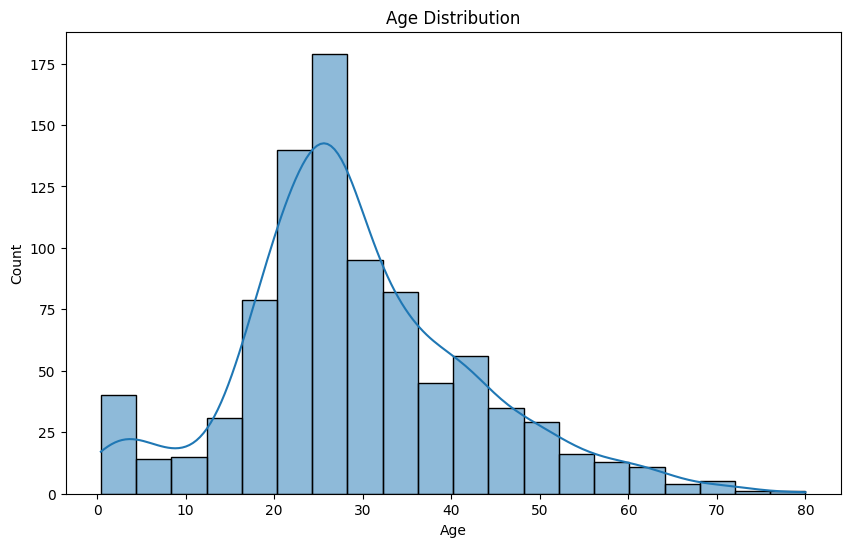

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [19]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.318643,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.281103,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.750000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.507589,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
train_df[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Age', ascending=False)

,Pclass,Age
0,1,38.378866
1,2,29.907295
2,3,25.112288


In [21]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


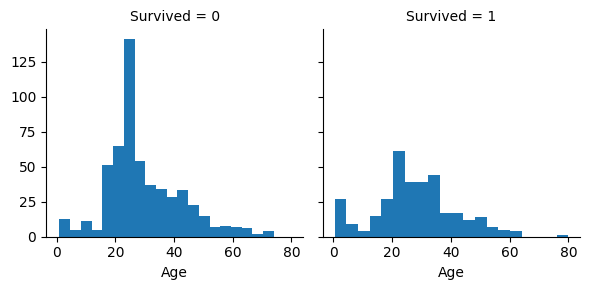

In [22]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## One hot encode categorical data 
- take text data like Sex and Embarked and split them into binary columns of different cateories
- aka one hot encoding

In [23]:
# one hot encode sex and embarked columns
encoder = OneHotEncoder()
sex_arr = encoder.fit_transform(train_df[['Sex']]).toarray()

# split sex column into male and female columns
categories = ['female', 'male']
for i in range(len(sex_arr.T)):
    train_df[categories[i]] = sex_arr.T[i]

sex_arr = encoder.fit_transform(test_df[['Sex']]).toarray()

# split sex column into male and female columns
categories = ['female', 'male']
for i in range(len(sex_arr.T)):
    test_df[categories[i]] = sex_arr.T[i]


In [24]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male
0,1,0,3,male,22.0,1,0,7.2500,S,0.0,1.0
1,2,1,1,female,38.0,1,0,71.2833,C,1.0,0.0
2,3,1,3,female,26.0,0,0,7.9250,S,1.0,0.0
3,4,1,1,female,35.0,1,0,53.1000,S,1.0,0.0
4,5,0,3,male,35.0,0,0,8.0500,S,0.0,1.0


In [25]:
emb_arr = encoder.fit_transform(train_df[['Embarked']]).toarray()

# split sex column into male and female columns
categories = ['C','S','Q','N']
for i in range(len(emb_arr.T)):
    train_df[categories[i]] = emb_arr.T[i]

emb_arr = encoder.fit_transform(test_df[['Embarked']]).toarray()

# split sex column into male and female columns
categories = ['C','S','Q','N']
for i in range(len(emb_arr.T)):
    test_df[categories[i]] = emb_arr.T[i]

In [26]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male,C,S,Q
0,1,0,3,male,22.0,1,0,7.2500,S,0.0,1.0,0.0,0.0,1.0
1,2,1,1,female,38.0,1,0,71.2833,C,1.0,0.0,1.0,0.0,0.0
2,3,1,3,female,26.0,0,0,7.9250,S,1.0,0.0,0.0,0.0,1.0
3,4,1,1,female,35.0,1,0,53.1000,S,1.0,0.0,0.0,0.0,1.0
4,5,0,3,male,35.0,0,0,8.0500,S,0.0,1.0,0.0,0.0,1.0


In [27]:
# remove uneeded columns
train_df = train_df.drop(columns=['Sex', 'Embarked'])
test_df = test_df.drop(columns=['Sex', 'Embarked'])
train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,1,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [28]:
test_df

,PassengerId,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,892,3,34.500000,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,893,3,47.000000,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,894,2,62.000000,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,895,3,27.000000,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,896,3,22.000000,1,1,12.2875,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,24.525104,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
414,1306,1,39.000000,0,0,108.9000,1.0,0.0,1.0,0.0,0.0
415,1307,3,38.500000,0,0,7.2500,0.0,1.0,0.0,0.0,1.0
416,1308,3,24.525104,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


## Normalize Data Points
- use standard scaler to make 0 the mean and 1 the standard deviation

In [29]:
def normalize_data(df):
    numeric_data = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(numeric_data)
    norm_df = pd.DataFrame(norm_data, columns=numeric_data.columns)
    df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = norm_df

normalize_data(train_df)
normalize_data(test_df)

In [30]:
train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,1,0,0.827377,-0.551366,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,2,1,-1.566107,0.654030,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,3,1,0.827377,-0.250017,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,4,1,-1.566107,0.428018,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,5,0,0.827377,0.428018,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


In [31]:
test_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,892,0.873482,0.392121,-0.499470,-0.400248,-0.497374,0.0,1.0,0.0,1.0,0.0
1,893,0.873482,1.357557,0.616992,-0.400248,-0.512238,1.0,0.0,0.0,0.0,1.0
2,894,-0.315819,2.516080,-0.499470,-0.400248,-0.464061,0.0,1.0,0.0,1.0,0.0
3,895,0.873482,-0.187140,-0.499470,-0.400248,-0.482436,0.0,1.0,0.0,0.0,1.0
4,896,0.873482,-0.573315,0.616992,0.619896,-0.417453,1.0,0.0,0.0,0.0,1.0


# Logistic Regression Model

In [32]:
# setup data
X = train_df.iloc[:, 2:]
Y = train_df.iloc[:, 1]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)

x_eval = test_df.iloc[:, 1:]

In [33]:
log_mod = LogisticRegression()

log_mod.fit(x_train, y_train)

y_pred = log_mod.predict(x_test)

In [34]:
print(f"accuracy of training set: {100*log_mod.score(x_train,y_train):.2f}%")
print(f"accuracy of training set: {100*log_mod.score(x_test,y_test):.2f}%")

accuracy of training set: 80.76%
accuracy of training set: 85.47%


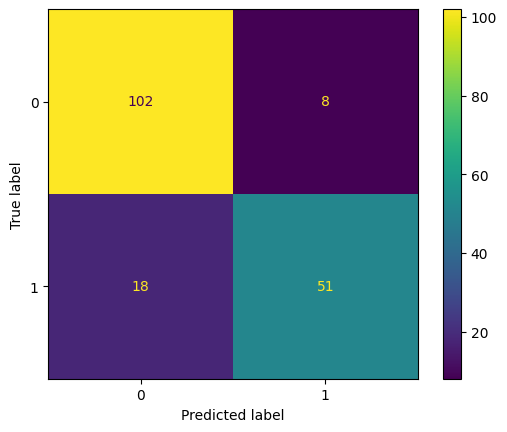

In [35]:
actual = y_test
predicted = y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [36]:
print(metrics.classification_report(y_test, y_pred, target_names={'Did not Survive', 'Survived'}))

                 precision    recall  f1-score   support

       Survived       0.85      0.93      0.89       110
Did not Survive       0.86      0.74      0.80        69

       accuracy                           0.85       179
      macro avg       0.86      0.83      0.84       179
   weighted avg       0.86      0.85      0.85       179



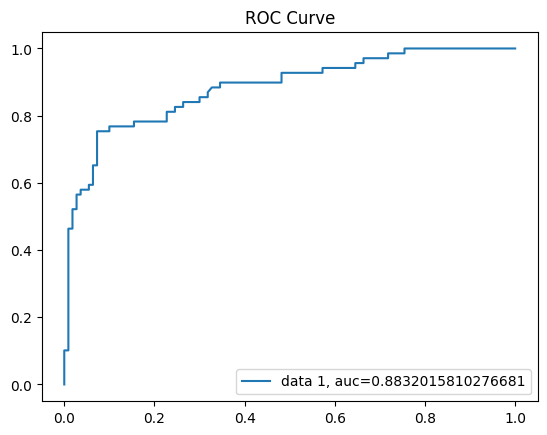

In [37]:
y_pred_proba = log_mod.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [38]:
def print_prediction(pred):
    if pred[0] == 1:
        print("This person probably survived")
    else:
        print("This person probably did not survive")

# P_class:3	Age: 27.0 sibsp:0 parch:0 Fare: 8.6625 Sex: Male Embarked to: Q
prediction_eval = log_mod.predict(x_eval.iloc[[3]])
print_prediction(prediction_eval)

This person probably did not survive


In [39]:
# P_class:1	Age: 39.0 sibsp:0 parch:0 Fare: 108.90 Sex: Female Embarked to: C
prediction_eval = log_mod.predict(x_eval.iloc[[414]])
print_prediction(prediction_eval)

This person probably survived


## Get Evaluation data results into csv file

In [40]:
prediction_eval = log_mod.predict(x_eval)

In [41]:
result_data = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
result_data = result_data.assign(Survived=prediction_eval)
result_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [44]:
result_data.to_csv("titanic_submission.csv", index=False)
!cat titanic_submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,0
912,0
913,0
914,1
915,1
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,0
925,0
926,0
927,0
928,1
929,1
930,0
931,0
932,0
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,0
942,1
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,1
961,1
962,1
963,0
964,1
965,1
966,1
967,1
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,0
982,1
983,0
984,1
985,0
986,1
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,0
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
10